<a href="https://colab.research.google.com/github/ethanmarshallanalytics/Deep-Learning-and-Neural-Networks/blob/main/MATH_6373_Homework_5_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

from google.colab import drive

drive.mount('/content/drive/')
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/cats-breed-dataset/', transform=preprocess)
dataset



Mounted at /content/drive/


Dataset ImageFolder
    Number of datapoints: 298
    Root location: /content/drive/MyDrive/cats-breed-dataset/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Image shape: torch.Size([10, 3, 224, 224])


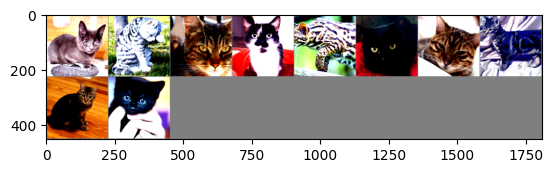

In [ ]:
from torch.utils.data import Subset
num_train_images = 10

train_data, test_data = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

train_subset = Subset(train_data, indices=range(num_train_images))

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=24, shuffle=True)

# display batch of images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

for images, labels in trainloader:
    # show images
    print("Image shape:", images.shape)
    imshow(torchvision.utils.make_grid(images))
    break  # Break after displaying the first batch

## Problem 1

In [ ]:
alexnet_model = models.alexnet(pretrained=True)
print(alexnet_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Problem 2

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/5: Train Loss: 2.5849, Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch 2/5: Train Loss: 0.0000, Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch 3/5: Train Loss: 0.0000, Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch 4/5: Train Loss: 0.0000, Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch 5/5: Train Loss: 0.0000, Test Loss: 0.0000, Test Accuracy: 1.0000


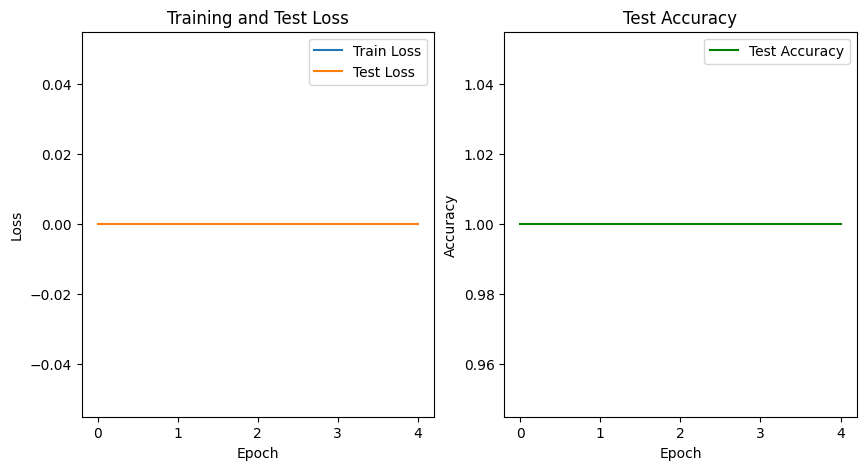

In [12]:
import torch
import matplotlib.pyplot as plt
import torchvision

from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

# Define transforms for the training data and testing data
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the Cats breed dataset
dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/cats-breed-dataset/', transform=preprocess)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64)

# LINE FROM MICHELA
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

# Freeze all layers except the last classifier layer
for param in model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer
num_classes = 5
classifier_input_size = model.classifier[6].in_features
classifier = nn.Sequential(
    nn.Linear(classifier_input_size, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes)
)
model.classifier[6] = classifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Training loop
epochs = 5
train_losses = []
test_losses = []
accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    test_loss = 0.0
    accuracy = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            test_loss += batch_loss.item() * inputs.size(0)  # Accumulate the loss
            _, predicted = torch.max(outputs, 1)
            accuracy += torch.sum(predicted == labels).item()
            total_samples += labels.size(0)

    # Calculate metrics
    test_loss = test_loss / total_samples
    accuracy = accuracy / total_samples

    # Store metrics for plotting
    test_losses.append(test_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {running_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test Accuracy: {accuracy:.4f}")

    model.train()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.show()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/5: Train Loss: 0.5320, Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch 2/5: Train Loss: 0.0000, Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch 3/5: Train Loss: 0.0000, Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch 4/5: Train Loss: 0.0000, Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch 5/5: Train Loss: 0.0000, Test Loss: 0.0000, Test Accuracy: 1.0000


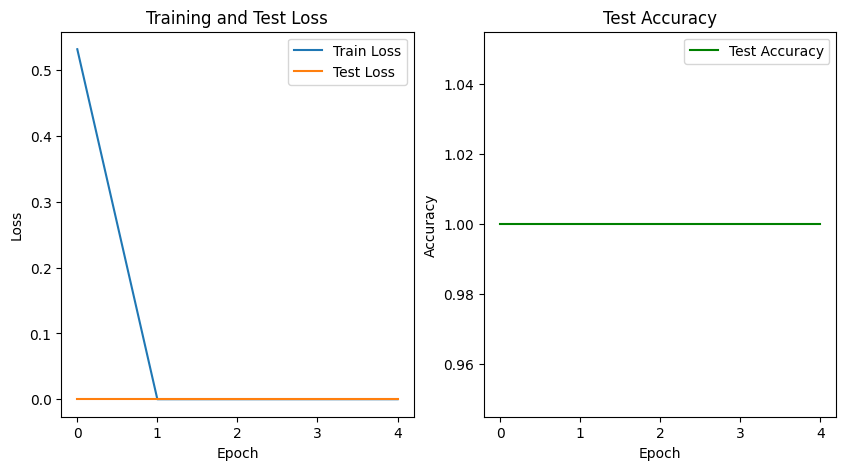

In [10]:
import torch
import matplotlib.pyplot as plt
import torchvision

from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/cats-breed-dataset/', transform=preprocess)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64)

# LINE FROM MICHELA
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

# Freeze layers up to a certain point
for param in model.features.parameters():
    param.requires_grad = False

# Modify the last fully connected layer
num_classes = 5
classifier_input_size = model.classifier[1].in_features
classifier = nn.Sequential(
    nn.Linear(classifier_input_size, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes)
)
model.classifier = classifier

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Optimizing all parameters

# Training loop
epochs = 5
train_losses = []
test_losses = []
accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    test_loss = 0.0
    accuracy = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            test_loss += batch_loss.item()
            _, predicted = torch.max(outputs, 1)
            accuracy += torch.sum(predicted == labels).item()

    train_loss = running_loss / len(trainloader)
    test_loss = test_loss / len(testloader)
    accuracy = accuracy / len(test_dataset)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test Accuracy: {accuracy:.4f}")

    model.train()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.show()



Epoch 1/5: Train Loss: 0.4637, Test Loss: 0.0039, Test Accuracy: 1.0000
Epoch 2/5: Train Loss: 0.0006, Test Loss: 0.0001, Test Accuracy: 1.0000
Epoch 3/5: Train Loss: 0.0000, Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch 4/5: Train Loss: 0.0000, Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch 5/5: Train Loss: 0.0000, Test Loss: 0.0000, Test Accuracy: 1.0000


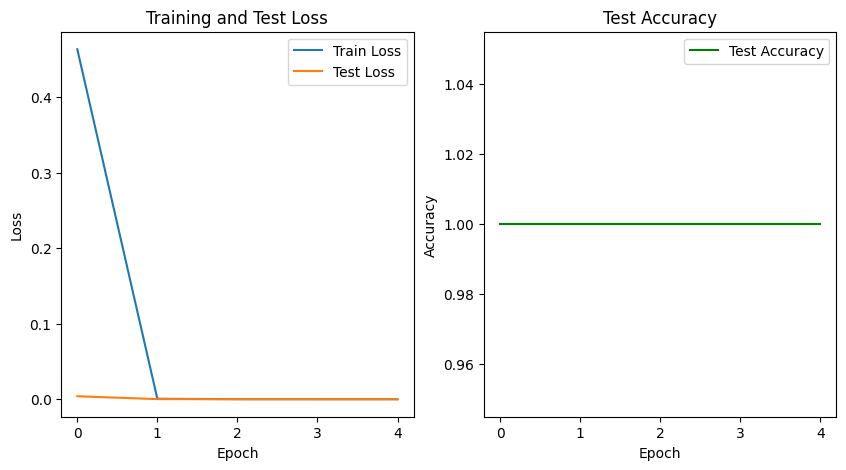

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision

from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/cats-breed-dataset/', transform=preprocess)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64)

# Load the pre-trained AlexNet model
model = models.alexnet(pretrained=True)

# Freeze all layers except the last classifier layer
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier
num_classes = 5
classifier_input_size = model.classifier[6].in_features
classifier = nn.Sequential(
    nn.Linear(classifier_input_size, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes)
)
model.classifier[6] = classifier

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0001)  # Only optimize the last layer

# Training loop
epochs = 5
train_losses = []
test_losses = []
accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    accuracy = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            test_loss += batch_loss.item()
            _, predicted = torch.max(outputs, 1)
            accuracy += torch.sum(predicted == labels).item()

    # Calculate metrics
    train_loss = running_loss / len(trainloader)
    test_loss = test_loss / len(testloader)
    accuracy = accuracy / len(test_dataset)

    # Store metrics for plotting
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test Accuracy: {accuracy:.4f}")

    model.train()  # Set model back to training mode

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.show()
